**Download the dataset archive of dishes With sideangles and extract it**

# Dataset Download & Prepare files
```

```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

zip_path = '/content/drive/MyDrive/side_angles.zip'
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

os.system(f'unzip -q "{zip_path}" -d "{extract_path}"')

0

In [ ]:
!cp -r '/content/drive/MyDrive/nutrition5k/metadata' '/content/dataset/metadata'
!cp -r '/content/drive/MyDrive/nutrition5k/dish_ids' '/content/dataset/dish_ids'

**Model**

# Dataset parsing

In [1]:
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F
from datetime import datetime
import timm
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
metadata_cafe1 = './dataset/metadata/dish_metadata_cafe1.csv'
# metadata_cafe1 = '../../nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'

In [3]:
def parse_file(data):
    data = data.split('\n')
    total = 0
    dishes = []
    df_data = []
    print("lines length: ", len(data))
    for line in data:
        line = line.strip()
        if line == '':
            continue
        line = line.split(',')

        num_ingredients = (len(line) - 6) // 7

        new_dish = {
            'dish_id': line[0],
            'total_calories': float(line[1]),
            'total_mass': float(line[2]),
            'total_fat': float(line[3]),
            'total_carbs': float(line[4]),
            'total_protein': float(line[5]),
        }
        dishes.append(line[0])

        total = total + 1
        for i in range(num_ingredients):
            ingredients = line[6+i*7:6+(i+1)*7]
            # print(ingredients)
            ingredient = {
                'ingredient_id': ingredients[0],
                'ingredient_name': ingredients[1],
                'ingredient_mass': float(ingredients[2]),
                'ingredient_calories': float(ingredients[3]),
                'ingredient_fat': float(ingredients[4]),
                'ingredient_carbs': float(ingredients[5]),
                'ingredient_protein': float(ingredients[6])
            }
            df_data.append({**new_dish, **ingredient})
    print("total dishes: ", total)
    return df_data, dishes


def read_and_parse_file(file_path):
    with open(file_path, 'r') as file:
        return parse_file(file.read())


df_data, dishes = read_and_parse_file(metadata_cafe1)
dishes_df = pd.DataFrame(dishes, columns=['dish_id'])

dataset = pd.DataFrame(df_data)

print("total shape", dataset.shape)
print("unique ingredient_ids", dataset['ingredient_id'].unique().shape)

print("unique dishes ids based only on ids from dataset: ",
      dishes_df['dish_id'].unique().shape)
print("unique dishes ids based on all combination ingredient - dish ",
      dataset['dish_id'].unique().shape)

lines length:  4769
total dishes:  4768
total shape (27225, 13)
unique ingredient_ids (211,)
unique dishes ids based only on ids from dataset:  (4768,)
unique dishes ids based on all combination ingredient - dish  (4768,)


In [4]:
def get_top_n_ingredients_by_mass(dataset, N=75):
    skip = ['olive oil', 'salt', 'pepper', 'vinegar', 'coffee',
            'plate only', 'vegetable oil', 'deprecated', 'sugar']

    dataset['ingredient_name'] = dataset['ingredient_name'].str.lower()
    filtered_dataset = dataset[~dataset['ingredient_name'].isin(skip)]

    ingredient_total_mass = filtered_dataset.groupby(
        'ingredient_name')['ingredient_mass'].sum().sort_values(ascending=False)

    top_N_ingredients = ingredient_total_mass.head(N).index.tolist()

    final_dataset = filtered_dataset[filtered_dataset['ingredient_name'].isin(
        top_N_ingredients)]

    return final_dataset


topIngredients = get_top_n_ingredients_by_mass(dataset, N=100)

topIngredients['dish_id']

,dish_id
1,dish_1561662216
2,dish_1561662216
4,dish_1561662216
5,dish_1561662216
7,dish_1561662216
...,...
27216,dish_1568664931
27218,dish_1568664931
27221,dish_1568664931
27222,dish_1568664931


ingredient_name
garlic      981
onions      711
broccoli    526
arugula     515
carrot      510
Name: count, dtype: int64


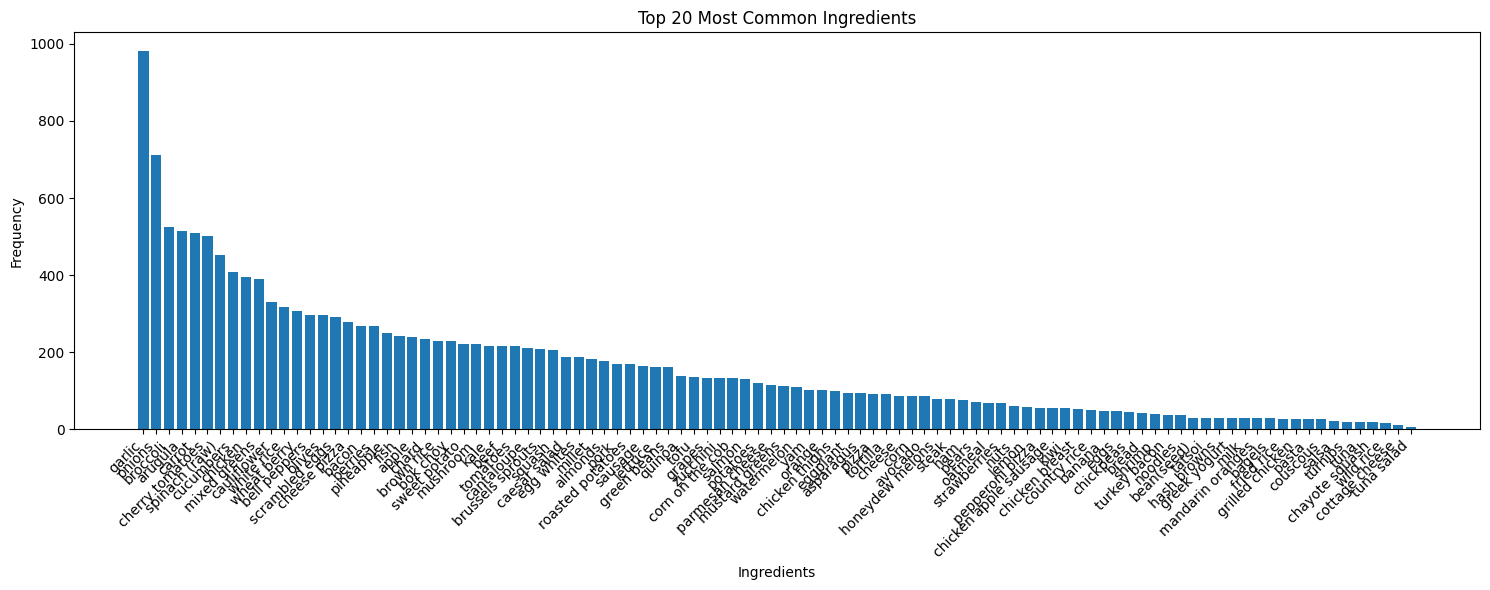

In [5]:
top75ingredientsByMass = topIngredients
ingredients_histogram = top75ingredientsByMass['ingredient_name'].value_counts(
)

print(ingredients_histogram.head())

plt.figure(figsize=(15, 6))

top_20_ingredients = ingredients_histogram

plt.bar(range(len(top_20_ingredients)), top_20_ingredients.values)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Ingredients')

plt.xticks(range(len(top_20_ingredients)),
           top_20_ingredients.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [6]:
test_split_ids = pd.read_csv(
    './dataset/dish_ids/splits/rgb_test_ids.txt', header=None)
train_split_ids = pd.read_csv(
    './dataset/dish_ids/splits/rgb_train_ids.txt', header=None)

dataset['split'] = 'unknown'

dataset['split'] = np.where(
    dataset['dish_id'].isin(train_split_ids[0]),
    'train',
    np.where(dataset['dish_id'].isin(test_split_ids[0]), 'test', 'unknown')
)

dataset['split'].value_counts()

,count
split,
train,23163
test,4062


In [16]:

dataset['fat_per_gram'] = dataset['total_fat'] / dataset['total_mass']
dataset['carbs_per_gram'] = dataset['total_carbs'] / dataset['total_mass']
dataset['protein_per_gram'] = dataset['total_protein'] / dataset['total_mass']

mask = (dataset['fat_per_gram'] <= 1) & \
       (dataset['carbs_per_gram'] <= 1) & \
       (dataset['protein_per_gram'] <= 1)

dataset_filtered = dataset[mask]

print(dataset_filtered.shape)
print(dataset.shape)
uniq_dishes = dataset_filtered.groupby('dish_id').first().reset_index()

print(uniq_dishes[['fat_per_gram', 'carbs_per_gram',
      'protein_per_gram']].describe())

(27207, 17)
(27225, 17)
       fat_per_gram  carbs_per_gram  protein_per_gram
count   4762.000000     4762.000000       4762.000000
mean       0.068836        0.103577          0.078140
std        0.094660        0.085017          0.074823
min        0.000000        0.000000          0.000000
25%        0.004447        0.044626          0.018033
50%        0.043572        0.082406          0.060000
75%        0.091628        0.137820          0.112860
max        0.540000        0.790000          0.370000


In [8]:
from sklearn.preprocessing import MinMaxScaler


class Nutrition5KDataset(Dataset):
    def __init__(self, dataset, root_dir, transform=None):
        self.dataset = dataset
        self.root_dir = root_dir
        self.transform = transform

        self.dish_dataset = dataset.groupby('dish_id').first().reset_index()
        self.dish_ids = self.dish_dataset['dish_id'].unique()

        self.fat_scaler = MinMaxScaler()
        self.carbs_scaler = MinMaxScaler()
        self.protein_scaler = MinMaxScaler()

        self.nutrition_data = self.dish_dataset[[
            'fat_per_gram', 'carbs_per_gram', 'protein_per_gram']].copy()

        self.nutrition_data['fat_per_gram'] = self.fat_scaler.fit_transform(
            self.nutrition_data[['fat_per_gram']])
        self.nutrition_data['carbs_per_gram'] = self.carbs_scaler.fit_transform(
            self.nutrition_data[['carbs_per_gram']])
        self.nutrition_data['protein_per_gram'] = self.protein_scaler.fit_transform(
            self.nutrition_data[['protein_per_gram']])

        print(self.nutrition_data.describe())

        self.image_paths = []
        self.label_indices = []
        self.dish_to_idx = {dish_id: idx for idx,
                            dish_id in enumerate(self.dish_ids)}

        for dish_id in self.dish_ids:
            dish_path = os.path.join(root_dir, str(dish_id), 'frames')

            if not os.path.exists(dish_path):
                continue

            for img_file in os.listdir(dish_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(dish_path, img_file))
                    self.label_indices.append(self.dish_to_idx[dish_id])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        fat = self.nutrition_data.iloc[self.label_indices[idx]]['fat_per_gram']
        carbs = self.nutrition_data.iloc[self.label_indices[idx]
                                         ]['carbs_per_gram']
        protein = self.nutrition_data.iloc[self.label_indices[idx]
                                           ]['protein_per_gram']

        return (image,
                torch.tensor([fat], dtype=torch.float32),
                torch.tensor([carbs], dtype=torch.float32),
                torch.tensor([protein], dtype=torch.float32)
                )

    def get_fat_scaler(self):
        return self.fat_scaler

    def get_carbs_scaler(self):
        return self.carbs_scaler

    def get_protein_scaler(self):
        return self.protein_scaler


nutrition5kDataset = Nutrition5KDataset(dataset, './dataset/side_angles')

       fat_per_gram  carbs_per_gram  protein_per_gram
count   4768.000000     4768.000000       4768.000000
mean       0.012923        0.019535          0.116207
std        0.026540        0.028055          0.113630
min        0.000000        0.000000          0.000000
25%        0.000817        0.008107          0.026595
50%        0.007920        0.014991          0.088488
75%        0.016689        0.025038          0.166975
max        1.000000        1.000000          1.000000


In [9]:
class MacronutrientLoss(nn.Module):
    def __init__(self, weights=None):
        super(MacronutrientLoss, self).__init__()
        self.mae = nn.L1Loss()

        self.weights = weights if weights is not None else [1.0, 1.0, 1.0]

    def forward(self, predictions, targets):

        fat_loss = self.mae(predictions[:, 0], targets[:, 0])
        carbs_loss = self.mae(predictions[:, 1], targets[:, 1])
        protein_loss = self.mae(predictions[:, 2], targets[:, 2])

        total_loss = (self.weights[0] * fat_loss +
                      self.weights[1] * carbs_loss +
                      self.weights[2] * protein_loss)

        return total_loss, {
            'fat_loss': fat_loss.item(),
            'carbs_loss': carbs_loss.item(),
            'protein_loss': protein_loss.item()
        }

In [10]:
class MacronutrientPredictor(nn.Module):
    def __init__(self, model_variant='resnet50', freeze_backbone=False, freeze_stages=None):
        super(MacronutrientPredictor, self).__init__()
        self.model_variant = model_variant
        self.freeze_backbone = freeze_backbone
        self.freeze_stages = freeze_stages

        self.backbone = timm.create_model(
            model_variant,
            pretrained=True,
            num_classes=0,
            global_pool='avg'
        )

        self.feature_dim = 4096

        self.shared_features = nn.Sequential(
            nn.Linear(self.backbone.num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fat_head = self.create_macronutrient_head(self.feature_dim)
        self.carbs_head = self.create_macronutrient_head(self.feature_dim)
        self.protein_head = self.create_macronutrient_head(self.feature_dim)

        self._init_heads()
        self._apply_freezing()

    def create_macronutrient_head(self, input_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1)
        )

    def _apply_freezing(self):
        if self.freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        if self.freeze_stages:
            for name, param in self.backbone.named_parameters():
                for stage in self.freeze_stages:
                    if stage in name:
                        param.requires_grad = True

        total_params = sum(p.numel() for p in self.backbone.parameters())
        frozen_params = sum(p.numel()
                            for p in self.backbone.parameters() if not p.requires_grad)
        trainable_params = total_params - frozen_params

        print(f"Backbone parameters: {total_params:,}")
        print(
            f"Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
        print(
            f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

    def _init_heads(self):
        for head in [self.fat_head, self.carbs_head, self.protein_head]:
            for layer in head:
                if isinstance(layer, nn.Linear):
                    nn.init.normal_(layer.weight, std=0.01)
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        backbone_features = self.backbone(x)
        shared_features = self.shared_features(backbone_features)

        fat = self.fat_head(shared_features)
        carbs = self.carbs_head(shared_features)
        protein = self.protein_head(shared_features)

        predictions = torch.cat([fat, carbs, protein], dim=1)

        return predictions

    def predict_calories(self, x):
        """
        calories = 9*fat + 4*carbs + 4*protein
        """
        predictions = self.forward(x)
        fat, carbs, protein = predictions[:,
                                          0], predictions[:, 1], predictions[:, 2]
        calories = 9 * fat + 4 * carbs + 4 * protein
        return calories


def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


def create_dataloaders(dataset, root_dir, batch_size=32, num_workers=16, input_size=224):
    train_transform, val_transform = get_transforms(input_size=224)

    train_dataset = Nutrition5KDataset(
        dataset[dataset['split'] == 'train'], root_dir, transform=train_transform)
    val_dataset = Nutrition5KDataset(
        dataset[dataset['split'] == 'test'], root_dir, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


def start_training(model, criterion, dataset, root_dir,
                   epochs=10, batch_size=32, lr=1e-4, device='cuda', starting_epoch=0):

    history = {
        'train_loss': [],
        'val_loss': []
    }

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_loader, val_loader = create_dataloaders(
        dataset, root_dir, batch_size=batch_size
    )

    print(f"Training started on {device}")
    print(
        f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, fat, carbs, protein) in enumerate(train_loader):
            images = images.to(device)
            targets = torch.cat([fat, carbs, protein], dim=1).to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss, loss_dict = criterion(predictions, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | "
                      f"Fat: {loss_dict['fat_loss']:.4f} | "
                      f"Carbs: {loss_dict['carbs_loss']:.4f} | "
                      f"Protein: {loss_dict['protein_loss']:.4f}")

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for (images, fat, carbs, protein) in val_loader:
                images = images.to(device)
                targets = torch.cat([fat, carbs, protein], dim=1).to(device)
                predictions = model(images)
                loss, _ = criterion(predictions, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print("\n\n")
        print("=" * 60)
        print(f"Epoch {epoch+starting_epoch+1}/{starting_epoch+epochs} Complete | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")
        print("=" * 60)

        filename_time = datetime.now().strftime("%Y%m%d_%H%M%S")

        file_name = f'model_epoch_{starting_epoch+epoch+1}_{filename_time}.pth'
        torch.save(
            {
                "state_dict": model.state_dict(),
                "history": history,
                "fat_scaler": train_loader.dataset.get_fat_scaler(),
                "carbs_scaler": train_loader.dataset.get_carbs_scaler(),
                "protein_scaler": train_loader.dataset.get_protein_scaler(),
                "epoch:": starting_epoch + epoch + 1,
                "model_variant": model.model_variant,
            },
            file_name,
        )

    print("Training completed!")
    return model, history

In [11]:
# model = MacronutrientPredictor(model_variant='resnet101',freeze_backbone=True,freeze_stages=['layer4'])

# model.backbone

checkpoint = torch.load(
    './model_epoch_9_20250609_135154.pth', weights_only=False)

model = MacronutrientPredictor(model_variant='resnet101')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

criterion = MacronutrientLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model initialized successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

torch.cuda.empty_cache()
trained_model = start_training(
    model=model,
    criterion=criterion,
    dataset=dataset_filtered,
    root_dir='./dataset/side_angles',
    epochs=10,
    batch_size=256,
    lr=5e-5,
    device=device,
    starting_epoch=11
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Backbone parameters: 42,500,160
Frozen parameters: 0 (0.0%)
Trainable parameters: 42,500,160 (100.0%)
Model initialized successfully!
Model parameters: 118,030,403
Trainable model parameters: 118,030,403
       fat_per_gram  carbs_per_gram  protein_per_gram
count   4055.000000     4055.000000       4055.000000
mean       0.125394        0.130830          0.209076
std        0.171791        0.107559          0.199934
min        0.000000        0.000000          0.000000
25%        0.008046        0.056834          0.048649
50%        0.079280        0.103567          0.162162
75%        0.168693        0.173277          0.302703
max        1.000000        1.000000          1.000000
       fat_per_gram  carbs_per_gram  protein_per_gram
count    707.000000      707.000000        707.000000
mean       0.139413        0.161295          0.223304
std        0.193883        0.131274          0.214639
min        0.000000        0.000000          0.000000
25%        0.008796        0.066154     

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 | Batch 1/167 | Loss: 0.0981 | Fat: 0.0315 | Carbs: 0.0276 | Protein: 0.0391
Epoch 1/10 | Batch 11/167 | Loss: 0.1077 | Fat: 0.0392 | Carbs: 0.0241 | Protein: 0.0444
Epoch 1/10 | Batch 21/167 | Loss: 0.0988 | Fat: 0.0322 | Carbs: 0.0267 | Protein: 0.0400
Epoch 1/10 | Batch 31/167 | Loss: 0.0980 | Fat: 0.0287 | Carbs: 0.0263 | Protein: 0.0430
Epoch 1/10 | Batch 41/167 | Loss: 0.1008 | Fat: 0.0312 | Carbs: 0.0279 | Protein: 0.0417
Epoch 1/10 | Batch 51/167 | Loss: 0.0872 | Fat: 0.0302 | Carbs: 0.0219 | Protein: 0.0350
Epoch 1/10 | Batch 61/167 | Loss: 0.1023 | Fat: 0.0316 | Carbs: 0.0308 | Protein: 0.0399
Epoch 1/10 | Batch 71/167 | Loss: 0.0779 | Fat: 0.0261 | Carbs: 0.0207 | Protein: 0.0312
Epoch 1/10 | Batch 81/167 | Loss: 0.0909 | Fat: 0.0336 | Carbs: 0.0210 | Protein: 0.0363
Epoch 1/10 | Batch 91/167 | Loss: 0.0892 | Fat: 0.0305 | Carbs: 0.0246 | Protein: 0.0341
Epoch 1/10 | Batch 101/167 | Loss: 0.0992 | Fat: 0.0312 | Carbs: 0.0279 | Protein: 0.0400
Epoch 1/10 | Batch 11

KeyboardInterrupt: 

# Evaluation

In [12]:
best_model = torch.load(
    './model_epoch_15_20250609_144020.pth', weights_only=False)

trained_model = MacronutrientPredictor(model_variant='resnet101')
trained_model.load_state_dict(best_model['state_dict'])
trained_model.to(device)

Backbone parameters: 42,500,160
Frozen parameters: 0 (0.0%)
Trainable parameters: 42,500,160 (100.0%)


MacronutrientPredictor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256,

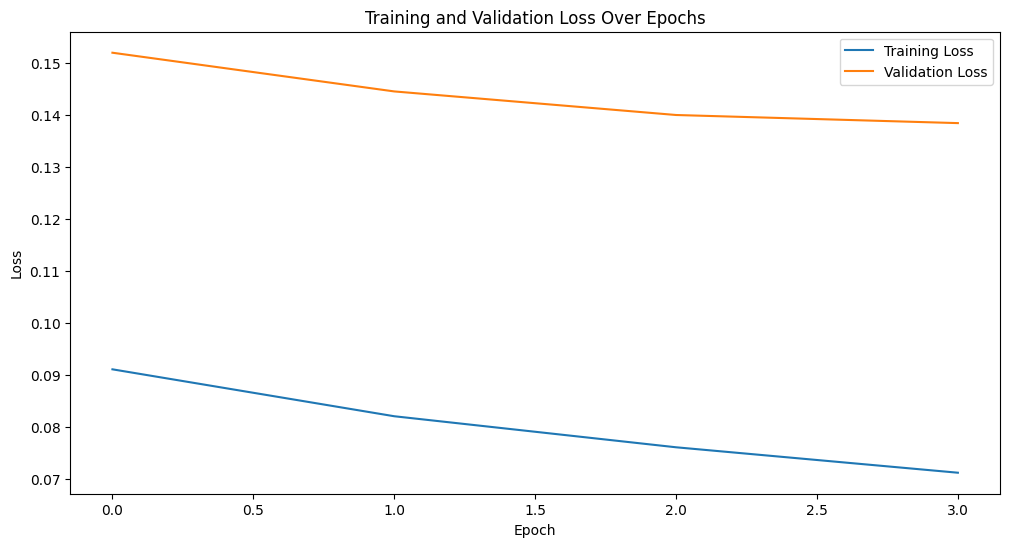

In [13]:
def plot_history(model):
    train_loss_history = model['history']['train_loss']
    val_loss_history = model['history']['val_loss']

    plt.figure(figsize=(12, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()


plot_history(best_model)

In [18]:
def eval_model(model, val_loader, fat_scaler, carbs_scaler, protein_scaler, criterion, device):
    model.eval()
    val_loss = 0.0
    mae = nn.L1Loss()

    # fat_scaler = val_loader.dataset.get_fat_scaler()
    # carbs_scaler = val_loader.dataset.get_carbs_scaler()
    # protein_scaler = val_loader.dataset.get_protein_scaler()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for (images, fat, carbs, protein) in val_loader:
            images = images.to(device)
            targets = torch.cat([fat, carbs, protein], dim=1).to(device)
            predictions = model(images)

            loss, _ = criterion(predictions, targets)
            val_loss += loss.item()

            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())

    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    pred_fat_per_gram = torch.from_numpy(fat_scaler.inverse_transform(
        all_predictions[:, 0].numpy().reshape(-1, 1)).flatten())
    pred_carbs_per_gram = torch.from_numpy(carbs_scaler.inverse_transform(
        all_predictions[:, 1].numpy().reshape(-1, 1)).flatten())
    pred_protein_per_gram = torch.from_numpy(protein_scaler.inverse_transform(
        all_predictions[:, 2].numpy().reshape(-1, 1)).flatten())

    true_fat_per_gram = torch.from_numpy(fat_scaler.inverse_transform(
        all_targets[:, 0].numpy().reshape(-1, 1)).flatten())
    true_carbs_per_gram = torch.from_numpy(carbs_scaler.inverse_transform(
        all_targets[:, 1].numpy().reshape(-1, 1)).flatten())
    true_protein_per_gram = torch.from_numpy(protein_scaler.inverse_transform(
        all_targets[:, 2].numpy().reshape(-1, 1)).flatten())

    dish_dataset = val_loader.dataset.dish_dataset
    total_masses = []

    for i in range(len(val_loader.dataset)):
        dish_idx = val_loader.dataset.label_indices[i]
        dish_id = val_loader.dataset.dish_ids[dish_idx]
        total_mass = dish_dataset[dish_dataset['dish_id']
                                  == dish_id]['total_mass'].iloc[0]
        total_masses.append(total_mass)

    total_masses = torch.tensor(total_masses, dtype=torch.float32)

    pred_fat_total = pred_fat_per_gram * total_masses
    pred_carbs_total = pred_carbs_per_gram * total_masses
    pred_protein_total = pred_protein_per_gram * total_masses

    true_fat_total = true_fat_per_gram * total_masses
    true_carbs_total = true_carbs_per_gram * total_masses
    true_protein_total = true_protein_per_gram * total_masses

    pred_calories = 9 * pred_fat_total + 4 * \
        pred_carbs_total + 4 * pred_protein_total
    true_calories = 9 * true_fat_total + 4 * \
        true_carbs_total + 4 * true_protein_total

    fat_mae_grams = mae(pred_fat_total, true_fat_total).item()
    carbs_mae_grams = mae(pred_carbs_total, true_carbs_total).item()
    protein_mae_grams = mae(pred_protein_total, true_protein_total).item()
    calorie_mae_kcal = mae(pred_calories, true_calories).item()

    mean_fat = true_fat_total.mean().item()
    mean_carbs = true_carbs_total.mean().item()
    mean_protein = true_protein_total.mean().item()
    mean_calories = true_calories.mean().item()

    pred_mean_fat = pred_fat_total.mean().item()
    pred_mean_carbs = pred_carbs_total.mean().item()
    pred_mean_protein = pred_protein_total.mean().item()
    pred_mean_calories = pred_calories.mean().item()

    fat_mae_percent = (fat_mae_grams / mean_fat) * 100
    carbs_mae_percent = (carbs_mae_grams / mean_carbs) * 100
    protein_mae_percent = (protein_mae_grams / mean_protein) * 100
    calorie_mae_percent = (calorie_mae_kcal / mean_calories) * 100

    avg_val_loss = val_loss / len(val_loader)

    results = {
        'val_loss': avg_val_loss,
        'mae_grams': {
            'fat': fat_mae_grams,
            'carbs': carbs_mae_grams,
            'protein': protein_mae_grams
        },
        'mae_kcal': {
            'calories': calorie_mae_kcal
        },
        'mae_percent_of_mean': {
            'fat': fat_mae_percent,
            'carbs': carbs_mae_percent,
            'protein': protein_mae_percent,
            'calories': calorie_mae_percent
        },
        'means': {
            'fat': mean_fat,
            'carbs': mean_carbs,
            'protein': mean_protein,
            'calories': mean_calories
        },
        'pred_means': {
            'fat': pred_mean_fat,
            'carbs': pred_mean_carbs,
            'protein': pred_mean_protein,
            'calories': pred_mean_calories
        }
    }

    print("=" * 60)
    print("VALIDATION RESULTS")
    print("=" * 60)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("\nMAE in Grams/Kcal:")
    print(f"  Fat MAE:      {fat_mae_grams:.2f}g")
    print(f"  Carbs MAE:    {carbs_mae_grams:.2f}g")
    print(f"  Protein MAE:  {protein_mae_grams:.2f}g")
    print(f"  Calorie MAE:  {calorie_mae_kcal:.2f} kcal")
    print("\nMAE as Percent of Mean:")
    print(f"  Fat MAE:      {fat_mae_percent:.1f}%")
    print(f"  Carbs MAE:    {carbs_mae_percent:.1f}%")
    print(f"  Protein MAE:  {protein_mae_percent:.1f}%")
    print(f"  Calorie MAE:  {calorie_mae_percent:.1f}%")
    print("\nMeans:")
    print(f"  Mean Fat:     {mean_fat:.2f}g")
    print(f"  Mean Carbs:   {mean_carbs:.2f}g")
    print(f"  Mean Protein: {mean_protein:.2f}g")
    print(f"  Mean Calories: {mean_calories:.2f} kcal")
    print("\nPred Means:")
    print(f"  Pred  Mean Fat:     {pred_mean_fat:.2f}g")
    print(f"  Pred  Mean Carbs:   {pred_mean_carbs:.2f}g")
    print(f"  Pred  Mean Protein: {pred_mean_protein:.2f}g")
    print(f"  Pred  Mean Calories: {pred_mean_calories:.2f} kcal")

    print("=" * 60)

    return results


def start_evaluation(model, root_dir='./dataset/side_angles'):
    train_loader, val_loader = create_dataloaders(
        dataset_filtered, root_dir, batch_size=256
    )

    criterion = MacronutrientLoss()

    eval_model(model,
               val_loader,
               train_loader.dataset.get_fat_scaler(),
               train_loader.dataset.get_carbs_scaler(),
               train_loader.dataset.get_protein_scaler(),
               criterion,
               device)


start_evaluation(trained_model)

       fat_per_gram  carbs_per_gram  protein_per_gram
count   4055.000000     4055.000000       4055.000000
mean       0.125394        0.130830          0.209076
std        0.171791        0.107559          0.199934
min        0.000000        0.000000          0.000000
25%        0.008046        0.056834          0.048649
50%        0.079280        0.103567          0.162162
75%        0.168693        0.173277          0.302703
max        1.000000        1.000000          1.000000
       fat_per_gram  carbs_per_gram  protein_per_gram
count    707.000000      707.000000        707.000000
mean       0.139413        0.161295          0.223304
std        0.193883        0.131274          0.214639
min        0.000000        0.000000          0.000000
25%        0.008796        0.066154          0.054054
50%        0.088592        0.132680          0.157770
75%        0.174074        0.215399          0.324324
max        1.000000        1.000000          1.000000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


VALIDATION RESULTS
Validation Loss: 0.1384

MAE in Grams/Kcal:
  Fat MAE:      2.83g
  Carbs MAE:    5.89g
  Protein MAE:  3.31g
  Calorie MAE:  40.13 kcal

MAE as Percent of Mean:
  Fat MAE:      24.5%
  Carbs MAE:    31.3%
  Protein MAE:  26.7%
  Calorie MAE:  17.5%

Means:
  Mean Fat:     11.55g
  Mean Carbs:   18.80g
  Mean Protein: 12.42g
  Mean Calories: 228.87 kcal

Pred Means:
  Pred  Mean Fat:     11.28g
  Pred  Mean Carbs:   14.11g
  Pred  Mean Protein: 11.24g
  Pred  Mean Calories: 202.94 kcal


       fat_per_gram  carbs_per_gram  protein_per_gram
count   4055.000000     4055.000000       4055.000000
mean       0.125394        0.130830          0.209076
std        0.171791        0.107559          0.199934
min        0.000000        0.000000          0.000000
25%        0.008046        0.056834          0.048649
50%        0.079280        0.103567          0.162162
75%        0.168693        0.173277          0.302703
max        1.000000        1.000000          1.000000
       fat_per_gram  carbs_per_gram  protein_per_gram
count    707.000000      707.000000        707.000000
mean       0.139413        0.161295          0.223304
std        0.193883        0.131274          0.214639
min        0.000000        0.000000          0.000000
25%        0.008796        0.066154          0.054054
50%        0.088592        0.132680          0.157770
75%        0.174074        0.215399          0.324324
max        1.000000        1.000000          1.000000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


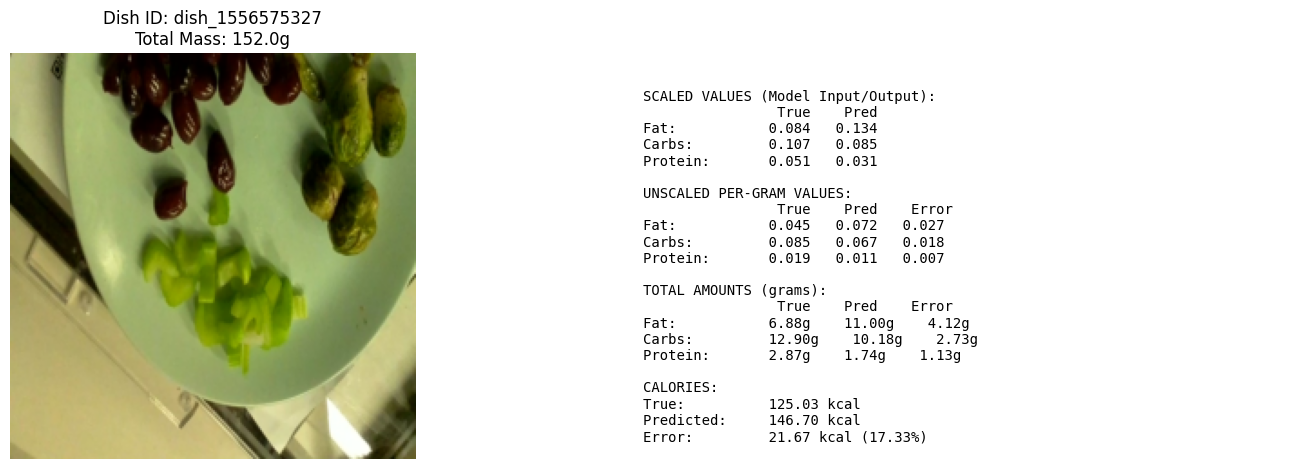

In [42]:
def test_for_one_image(model, data_loader, fat_scaler, protein_scaler, carbs_scaler, device='cuda'):
    model.eval()

    rand_idx = np.random.randint(0, len(data_loader.dataset))
    image, fat, carbs, protein = data_loader.dataset[rand_idx]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)

    pred_fat_per_gram_scaled = predictions[:, 0].item()
    pred_carbs_per_gram_scaled = predictions[:, 1].item()
    pred_protein_per_gram_scaled = predictions[:, 2].item()

    true_fat_per_gram_scaled = fat.item()
    true_carbs_per_gram_scaled = carbs.item()
    true_protein_per_gram_scaled = protein.item()

    true_fat_per_gram_unscaled = fat_scaler.inverse_transform(
        [[true_fat_per_gram_scaled]])[0][0]
    true_carbs_per_gram_unscaled = carbs_scaler.inverse_transform(
        [[true_carbs_per_gram_scaled]])[0][0]
    true_protein_per_gram_unscaled = protein_scaler.inverse_transform(
        [[true_protein_per_gram_scaled]])[0][0]

    pred_fat_per_gram_unscaled = fat_scaler.inverse_transform(
        [[pred_fat_per_gram_scaled]])[0][0]
    pred_carbs_per_gram_unscaled = carbs_scaler.inverse_transform(
        [[pred_carbs_per_gram_scaled]])[0][0]
    pred_protein_per_gram_unscaled = protein_scaler.inverse_transform(
        [[pred_protein_per_gram_scaled]])[0][0]

    dish_idx = data_loader.dataset.label_indices[rand_idx]
    dish_id = data_loader.dataset.dish_ids[dish_idx]
    dish_info = data_loader.dataset.dish_dataset[data_loader.dataset.dish_dataset['dish_id'] == dish_id].iloc[0]
    total_mass = dish_info['total_mass']

    true_fat_total = true_fat_per_gram_unscaled * total_mass
    true_carbs_total = true_carbs_per_gram_unscaled * total_mass
    true_protein_total = true_protein_per_gram_unscaled * total_mass

    pred_fat_total = pred_fat_per_gram_unscaled * total_mass
    pred_carbs_total = pred_carbs_per_gram_unscaled * total_mass
    pred_protein_total = pred_protein_per_gram_unscaled * total_mass

    true_calories = 9 * true_fat_total + 4 * \
        true_carbs_total + 4 * true_protein_total
    pred_calories = 9 * pred_fat_total + 4 * \
        pred_carbs_total + 4 * pred_protein_total

    plt.figure(figsize=(15, 5))

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    img_display = image.clone()
    for i in range(3):
        img_display[i] = img_display[i] * std[i] + mean[i]

    img_display = torch.clamp(img_display, 0, 1)

    img_np = img_display.permute(1, 2, 0).numpy()

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f'Dish ID: {dish_id}\nTotal Mass: {total_mass:.1f}g')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.axis('off')

    comparison_text = f"""
        SCALED VALUES (Model Input/Output):
                        True    Pred
        Fat:           {true_fat_per_gram_scaled:.3f}   {pred_fat_per_gram_scaled:.3f}
        Carbs:         {true_carbs_per_gram_scaled:.3f}   {pred_carbs_per_gram_scaled:.3f}
        Protein:       {true_protein_per_gram_scaled:.3f}   {pred_protein_per_gram_scaled:.3f}

        UNSCALED PER-GRAM VALUES:
                        True    Pred    Error
        Fat:           {true_fat_per_gram_unscaled:.3f}   {pred_fat_per_gram_unscaled:.3f}   {abs(true_fat_per_gram_unscaled - pred_fat_per_gram_unscaled):.3f}
        Carbs:         {true_carbs_per_gram_unscaled:.3f}   {pred_carbs_per_gram_unscaled:.3f}   {abs(true_carbs_per_gram_unscaled - pred_carbs_per_gram_unscaled):.3f}
        Protein:       {true_protein_per_gram_unscaled:.3f}   {pred_protein_per_gram_unscaled:.3f}   {abs(true_protein_per_gram_unscaled - pred_protein_per_gram_unscaled):.3f}

        TOTAL AMOUNTS (grams):
                        True    Pred    Error
        Fat:           {true_fat_total:.2f}g    {pred_fat_total:.2f}g    {abs(true_fat_total - pred_fat_total):.2f}g
        Carbs:         {true_carbs_total:.2f}g    {pred_carbs_total:.2f}g    {abs(true_carbs_total - pred_carbs_total):.2f}g
        Protein:       {true_protein_total:.2f}g    {pred_protein_total:.2f}g    {abs(true_protein_total - pred_protein_total):.2f}g

        CALORIES:
        True:          {true_calories:.2f} kcal
        Predicted:     {pred_calories:.2f} kcal
        Error:         {abs(true_calories - pred_calories):.2f} kcal ({abs(true_calories - pred_calories)/true_calories*100:.2f}%)
    """

    plt.text(0.05, 0.95, comparison_text, fontfamily='monospace', fontsize=10,
             verticalalignment='top', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return {
        'dish_id': dish_id,
        'total_mass': total_mass,
        'scaled': {
            'true': [true_fat_per_gram_scaled, true_carbs_per_gram_scaled, true_protein_per_gram_scaled],
            'pred': [pred_fat_per_gram_scaled, pred_carbs_per_gram_scaled, pred_protein_per_gram_scaled]
        },
        'unscaled_per_gram': {
            'true': [true_fat_per_gram_unscaled, true_carbs_per_gram_unscaled, true_protein_per_gram_unscaled],
            'pred': [pred_fat_per_gram_unscaled, pred_carbs_per_gram_unscaled, pred_protein_per_gram_unscaled]
        },
        'total_amounts': {
            'true': [true_fat_total, true_carbs_total, true_protein_total],
            'pred': [pred_fat_total, pred_carbs_total, pred_protein_total]
        },
        'calories': {
            'true': true_calories,
            'pred': pred_calories
        }
    }


def test():
    checkpoint = torch.load(
        './model_epoch_15_20250609_144020.pth', weights_only=False)

    root_dir = './dataset/side_angles'
    train_loader, val_loader = create_dataloaders(
        dataset_filtered, root_dir, batch_size=256
    )

    result = test_for_one_image(
        trained_model,
        val_loader,
        checkpoint['fat_scaler'],
        checkpoint['protein_scaler'],
        checkpoint['carbs_scaler'],
        device
    )

    return result


result = test()